In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from glob import glob
import seaborn as sb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
df_data = pd.read_csv(('data/train.csv'))
df_data.sample()

,track,tags
40860,44600,"3,6,28,232,251"


In [3]:
track_idx2embeds = {}
for track_idx in tqdm(df_data['track']):
    fn = f"data/track_embeddings\\{track_idx}.npy"
    embeds = np.load(fn)
    track_idx2embeds[track_idx] = embeds
print(len(track_idx2embeds))

100%|██████████| 51134/51134 [01:21<00:00, 628.46it/s] 

51134


In [4]:
def tag_in_row(a, tag):
    idxs = []
    for i, row in enumerate(a):
        if tag in row:
            idxs.append(i)
    return idxs

def tag_notin_row(a, tag):
    idxs = []
    for i, row in enumerate(a):
        if tag not in row:
            idxs.append(i)
    return idxs

In [42]:
tag = '95'
df_data_pos = df_data.iloc[tag_in_row(df_data['tags'], tag)]
df_data_neg = df_data.iloc[tag_notin_row(df_data['tags'], tag)]

In [43]:
emb_pos_mean = 0
for track_idx in tqdm(df_data_pos['track']):
    emb_pos_mean += track_idx2embeds[track_idx].mean(axis=0)
emb_pos_mean /= len(df_data_pos['track'])
emb_pos_mean.shape

100%|██████████| 931/931 [00:00<00:00, 19543.93it/s]


(768,)

In [46]:
emb_neg_mean = 0
for track_idx in tqdm(df_data_neg['track']):
    emb_neg_mean += track_idx2embeds[track_idx].mean(axis=0)
emb_neg_mean /= len(df_data_neg['track'])
emb_neg_mean.shape

100%|██████████| 50203/50203 [00:01<00:00, 26915.20it/s]


(768,)

<BarContainer object of 768 artists>

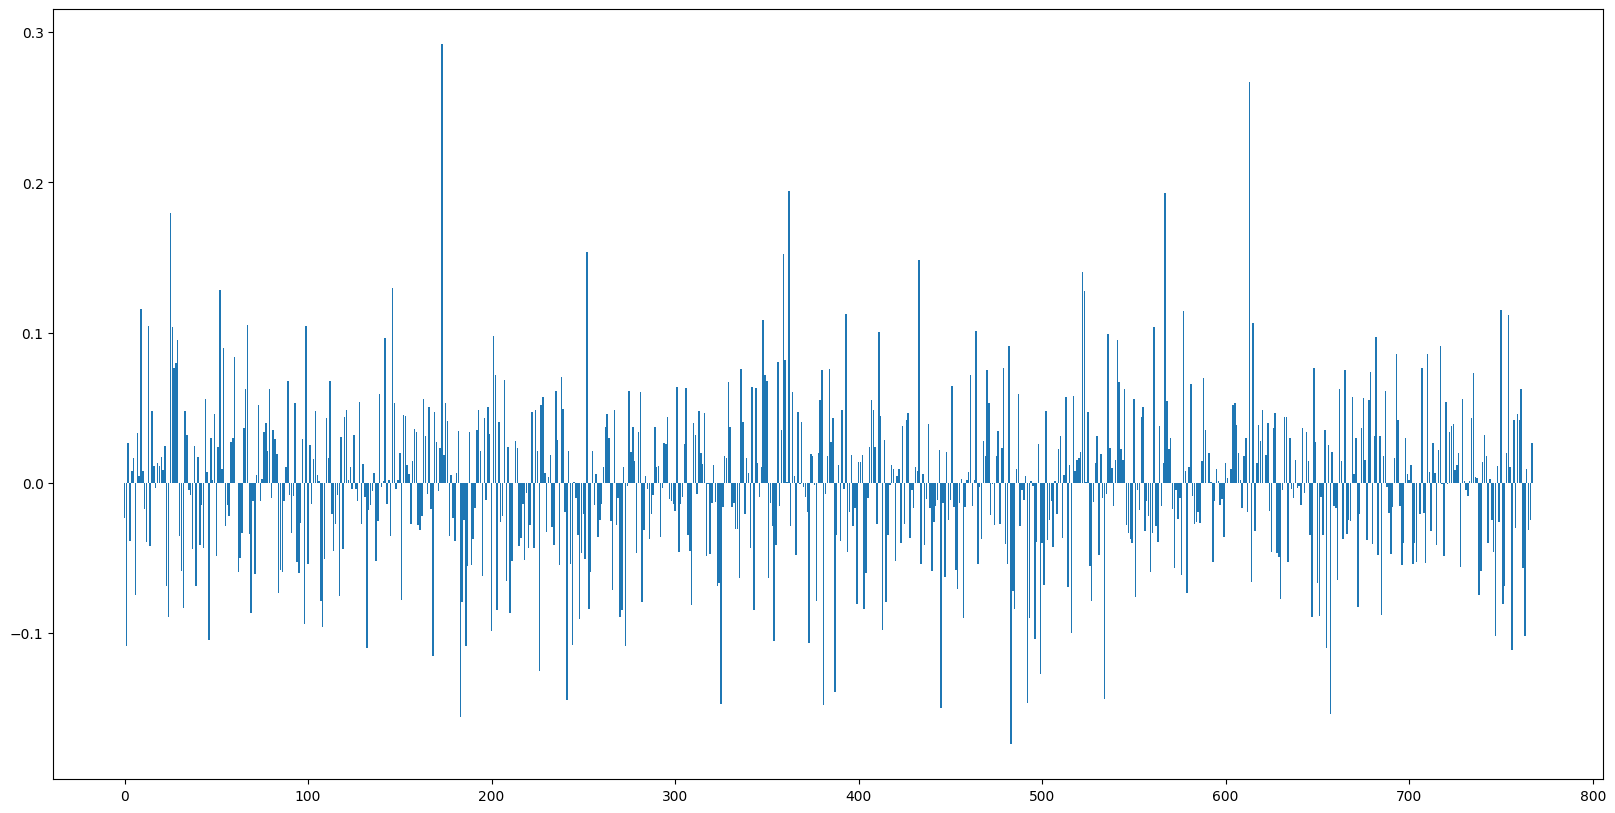

In [47]:
plt.figure(figsize=(20,10))
plt.bar(range(768), emb_pos_mean - emb_neg_mean)

In [26]:
emb_train_mean = 0
for track_idx in tqdm(df_data['track']):
    emb_train_mean += track_idx2embeds[track_idx].mean(axis=0)
emb_train_mean /= len(df_data['track'])
emb_train_mean.shape

100%|██████████| 1000/1000 [00:00<00:00, 12378.68it/s]


(768,)

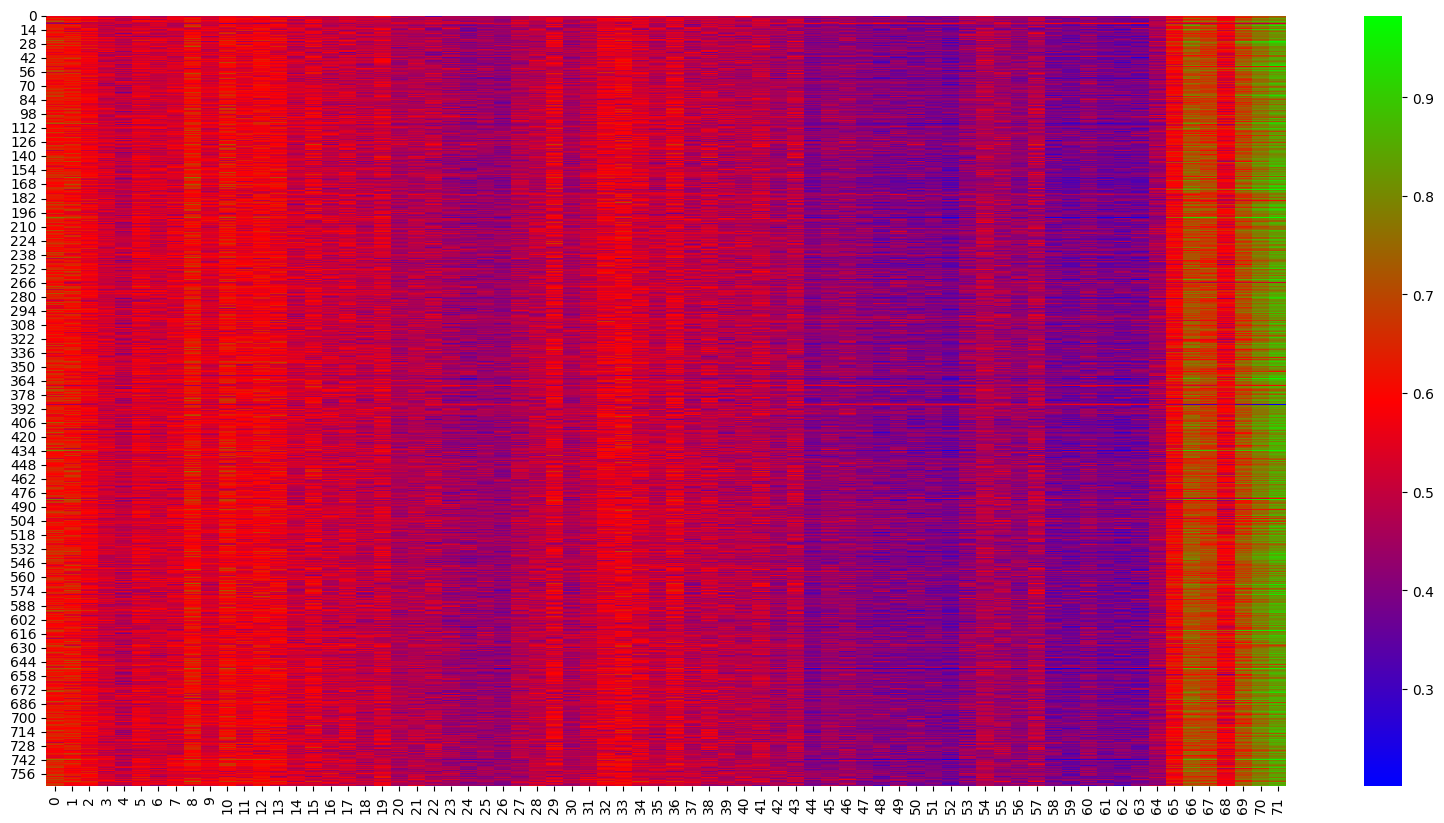

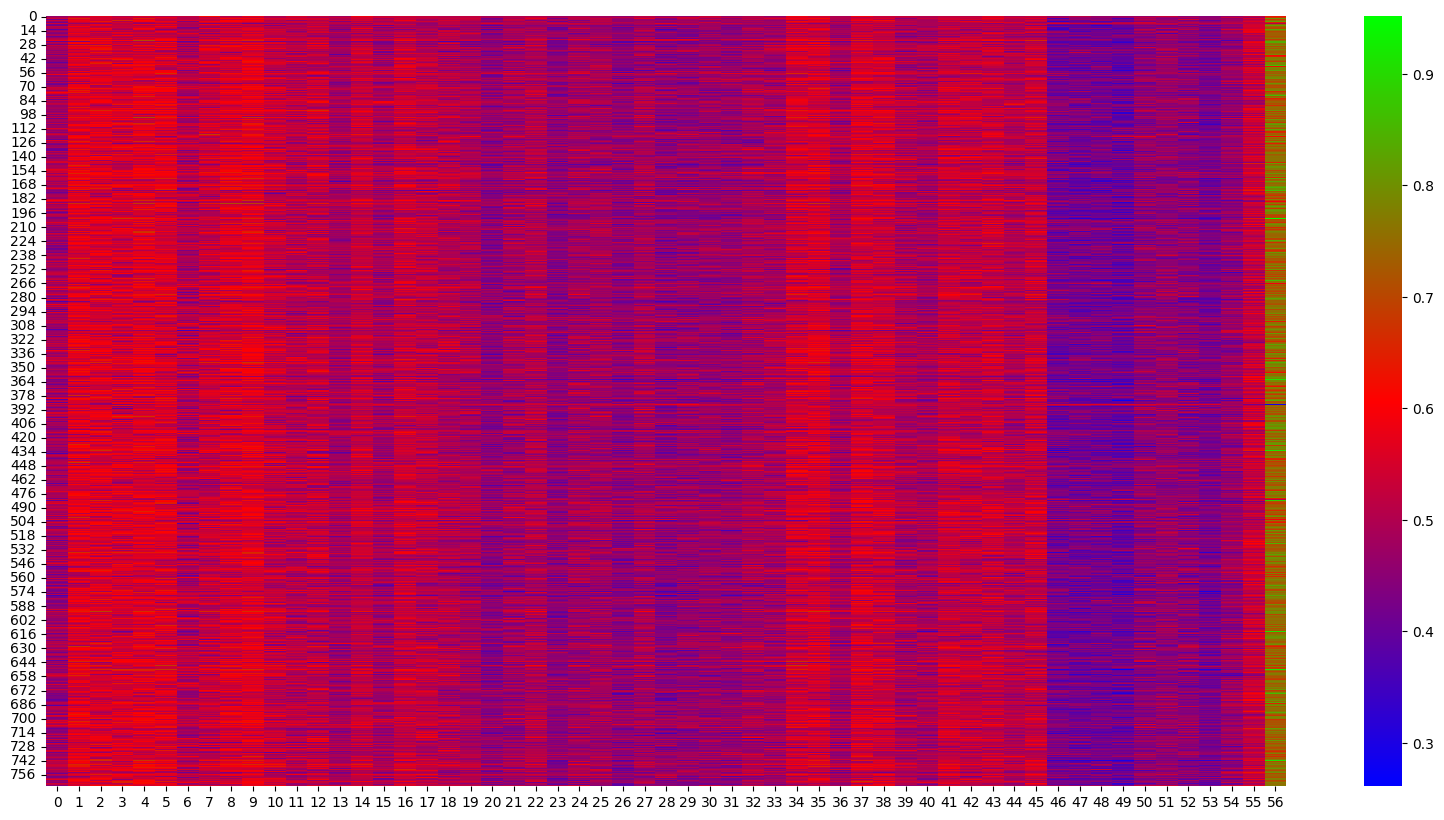

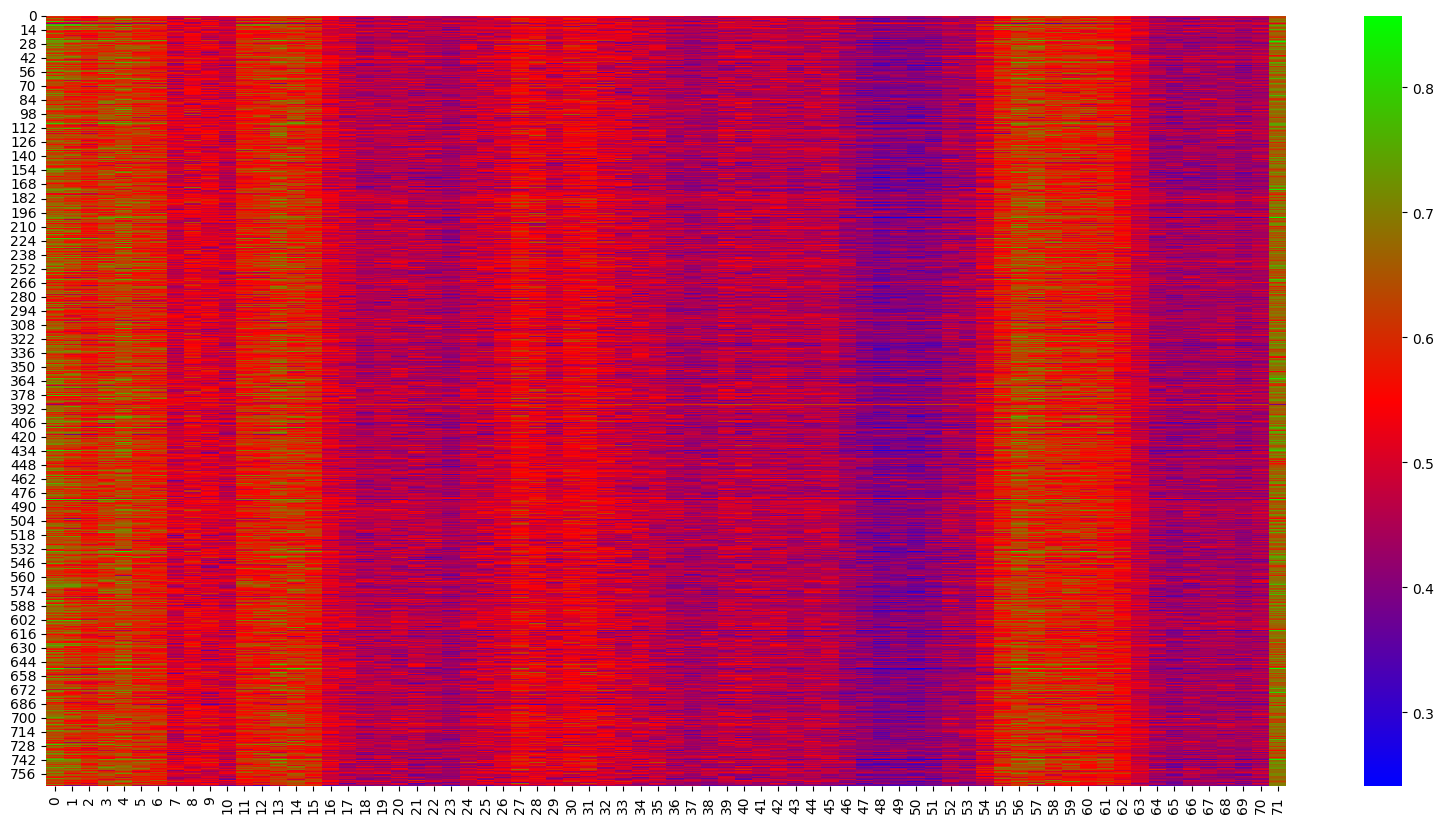

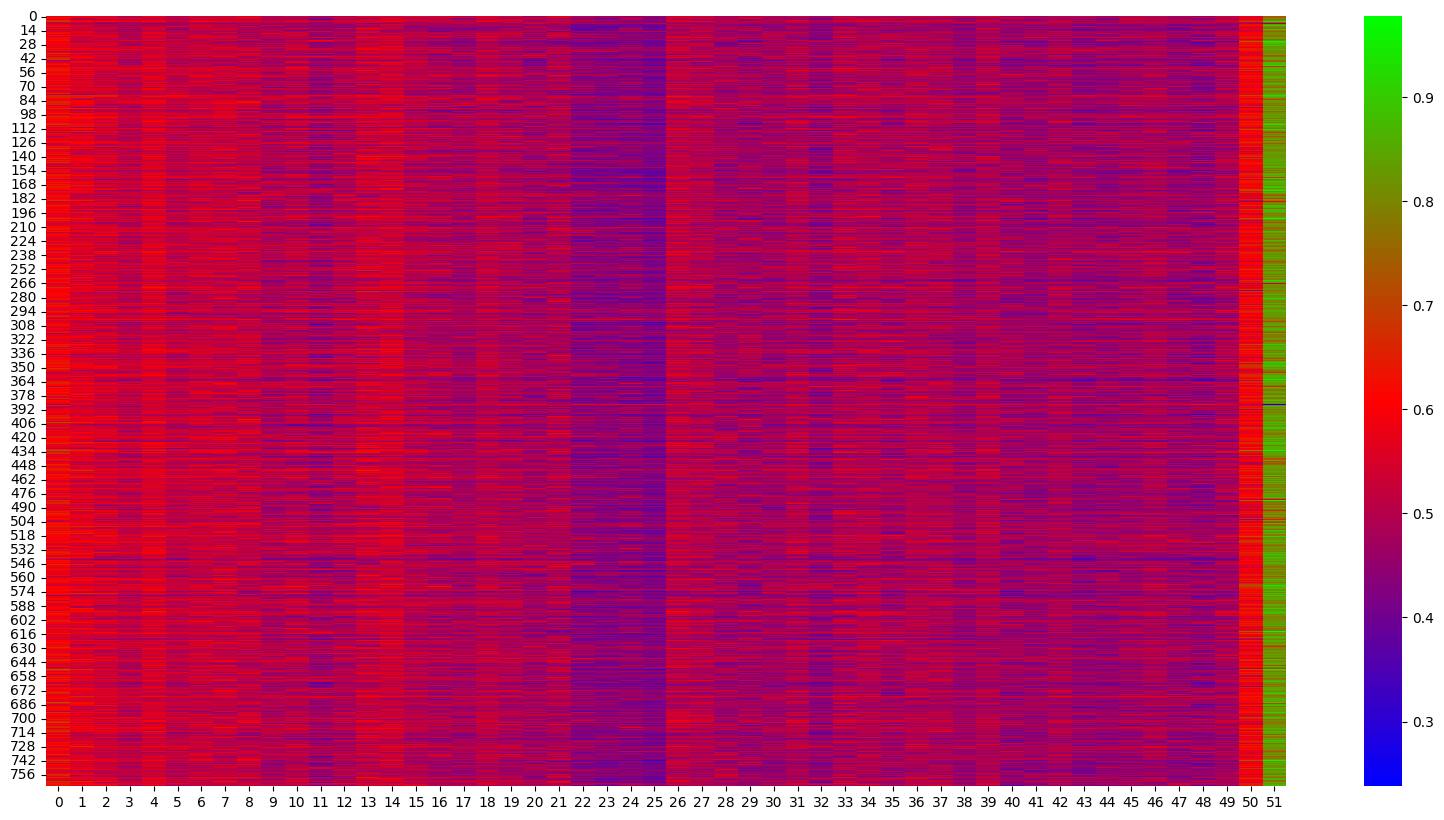

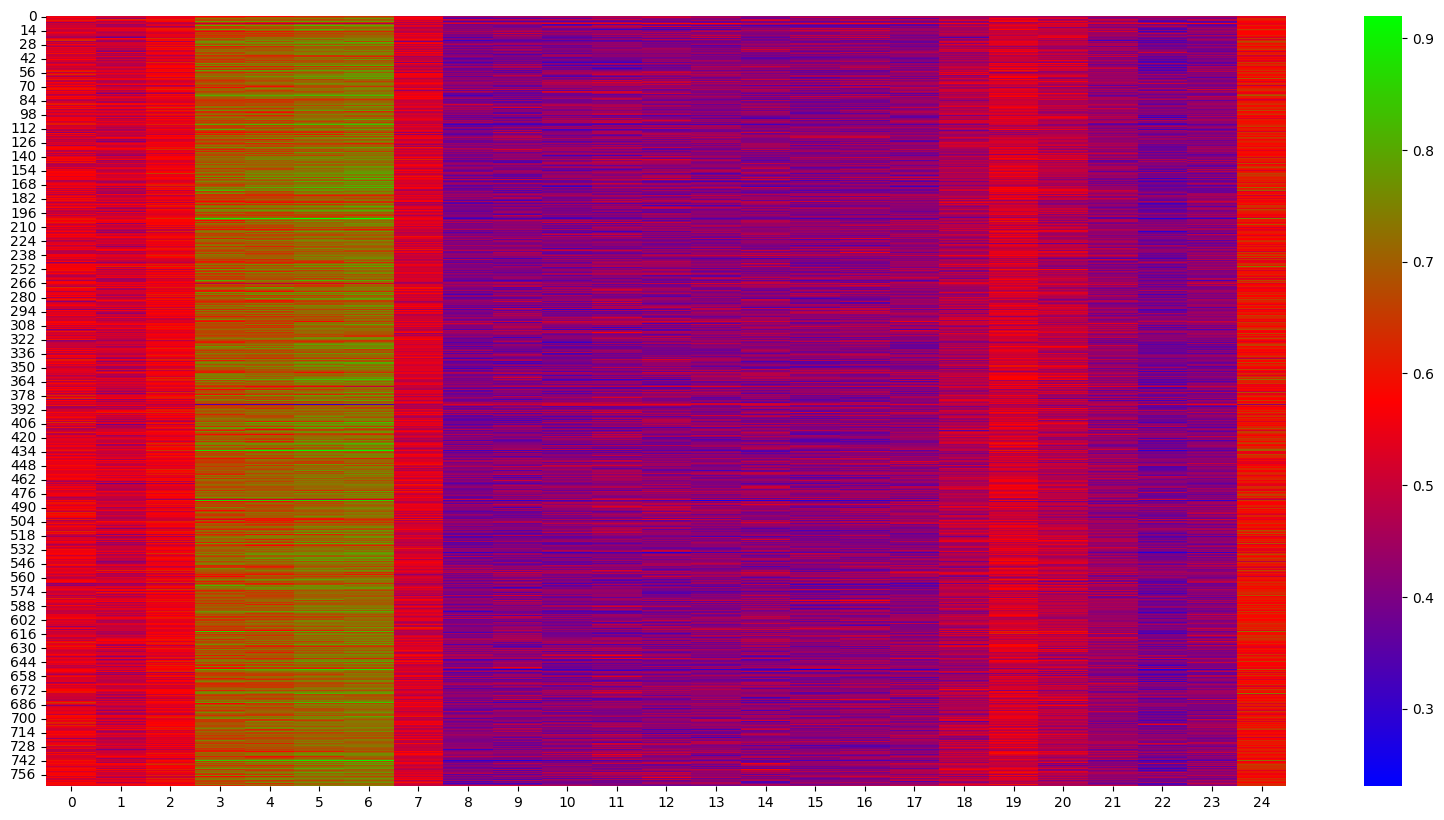

In [33]:
from matplotlib.colors import LogNorm
for track_id in list(track_idx2embeds.keys())[0:5]:
    plt.figure(figsize=(20,10))
    to_plot = track_idx2embeds[track_id].copy() - emb_train_mean
    # to_plot[abs(to_plot)>1] = 1
    to_plot = 1 / (1 + np.exp(-to_plot))
    sb.heatmap(to_plot.T, cmap="brg")  #, norm=LogNorm()

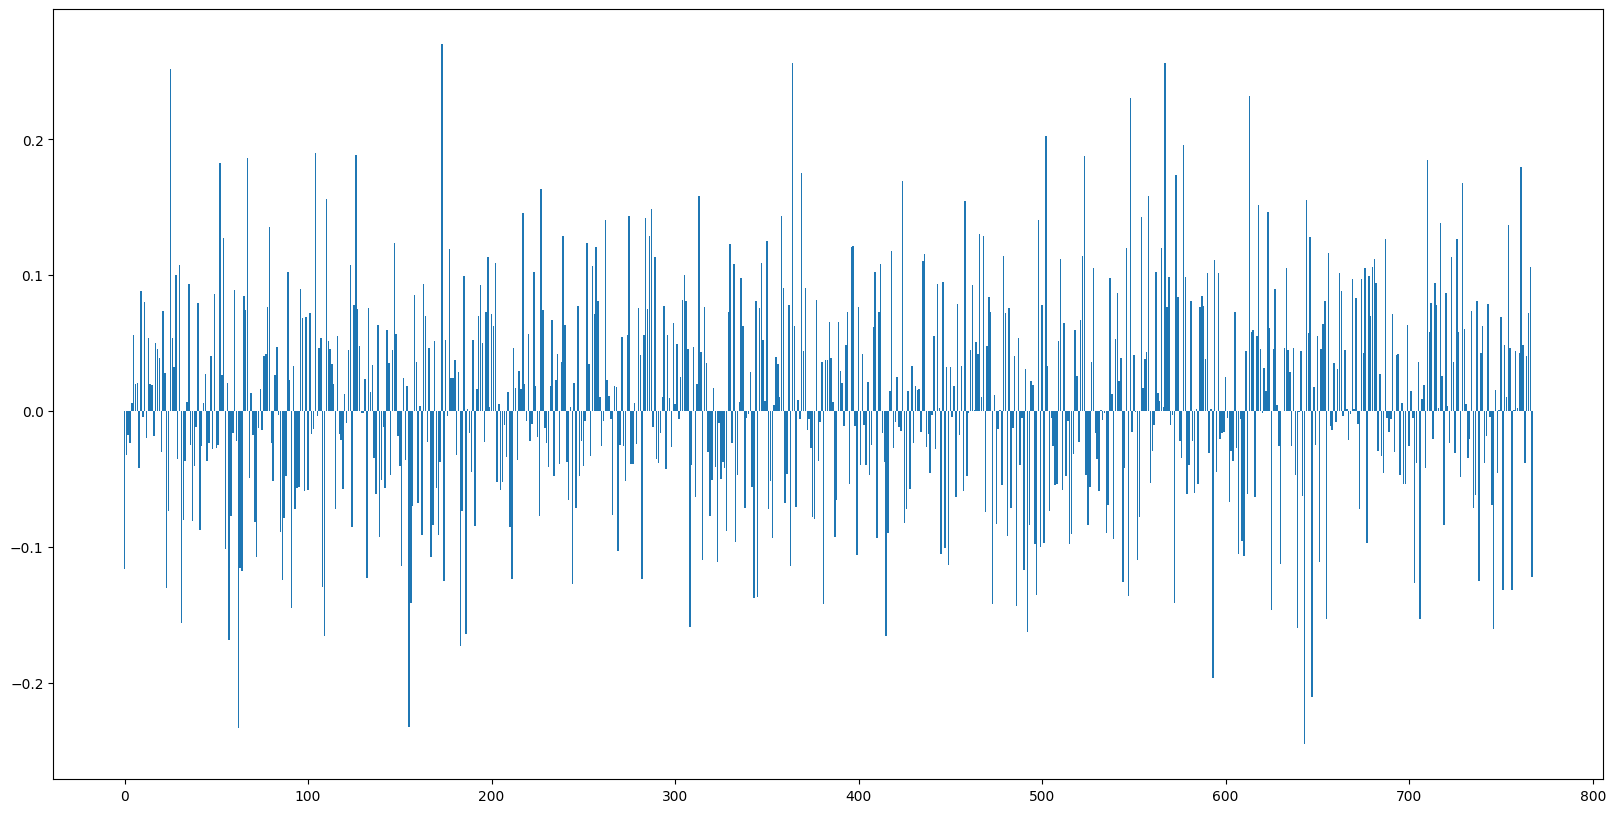

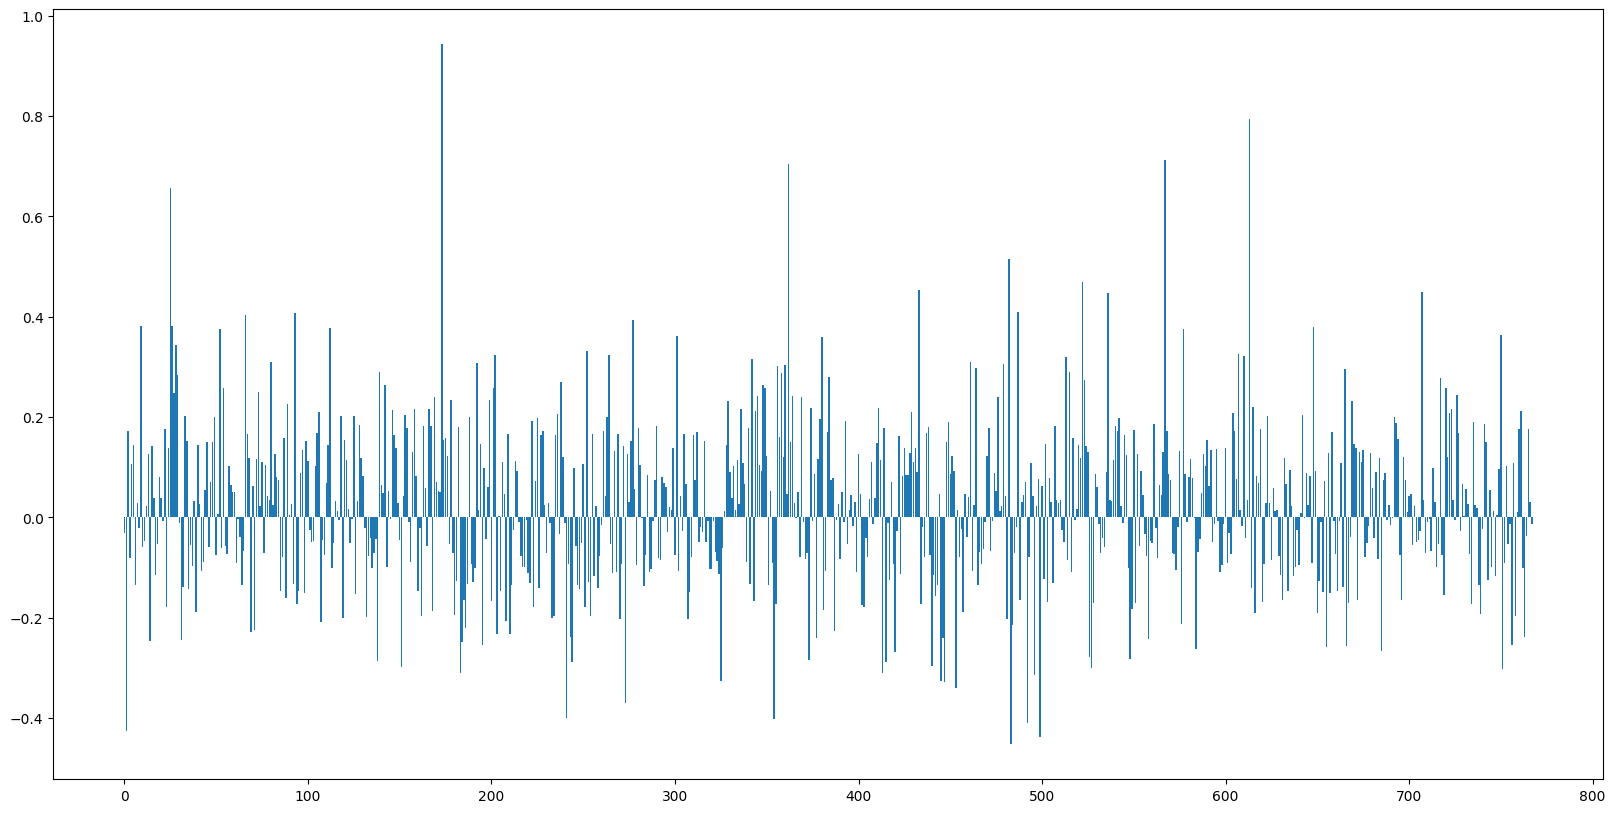

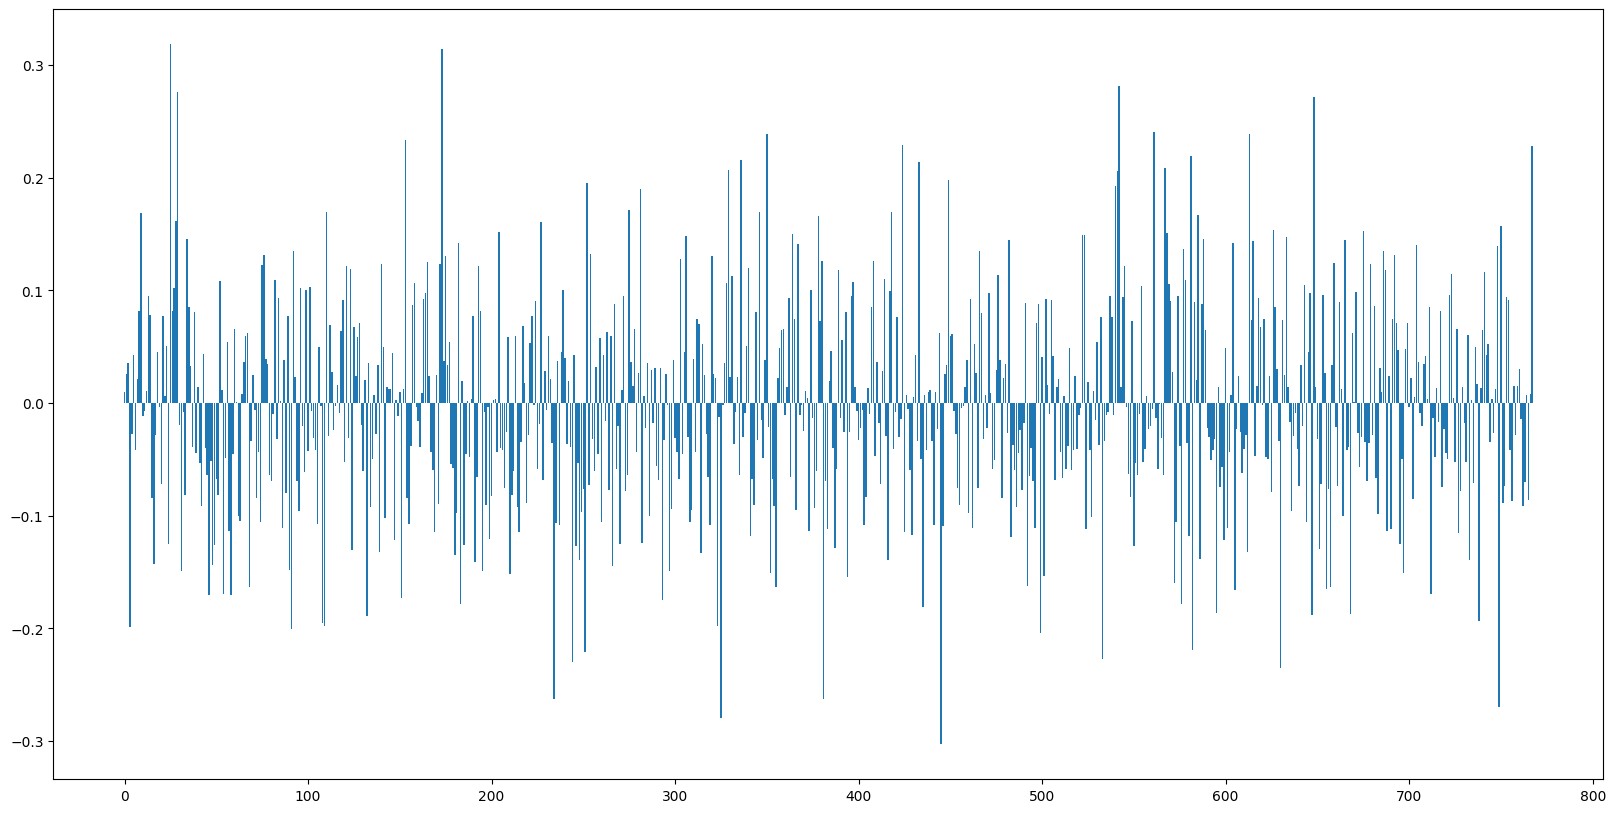

In [21]:
for i in range(3):
    plt.figure(figsize=(20,10))
    # for track_id in list(track_idx2embeds.keys())[10*i:10*i+2]:
    track_id_1 = list(track_idx2embeds.keys())[i*10]
    track_id_2 = list(track_idx2embeds.keys())[i*10+1]
    to_plot = track_idx2embeds[track_id_1].mean(axis=0) - track_idx2embeds[track_id_2].mean(axis=0)
    # to_plot = 1 / (1 + np.exp(-to_plot))
    plt.bar(range(to_plot.shape[0]), to_plot)

In [ ]:
df_datacorr = pd.DataFrame()
tags_1hot = []
tags_list = list(df_data['tags'])
for tags in tags_list:
    tags_1hot.append(np.zeros(256))
    tags_1hot[-1][[int(x) for x in tags.split(',')]] = 1
tags_1hot = np.array(tags_1hot)
for i in range(256):
    df_datacorr[f'{i}'] = tags_1hot[:,i]


In [21]:
track_len = []
for track_idx in track_idx2embeds.keys():
    track_len.append(track_idx2embeds[track_idx].shape[0])
df_datacorr['len'] = track_len
df_datacorr


C:\Users\chemr\AppData\Local\Temp\ipykernel_14868\3555908583.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_datacorr['len'] = track_len


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,len
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51129,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68
51130,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57
51131,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83
51132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14


In [32]:
corr = df_datacorr.corr()

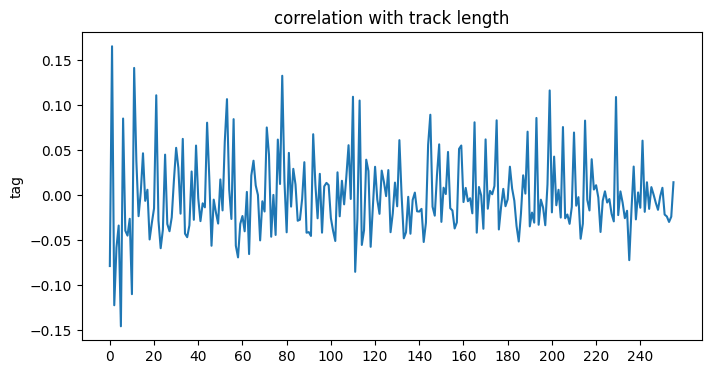

In [35]:
plt.figure(figsize=(8,4))
plt.xticks(range(0,255,20))
plt.ylabel("tag")
plt.title("correlation with track length")
plt.plot(corr['len'][:-1])

Text(0.5, 0, 'track length')

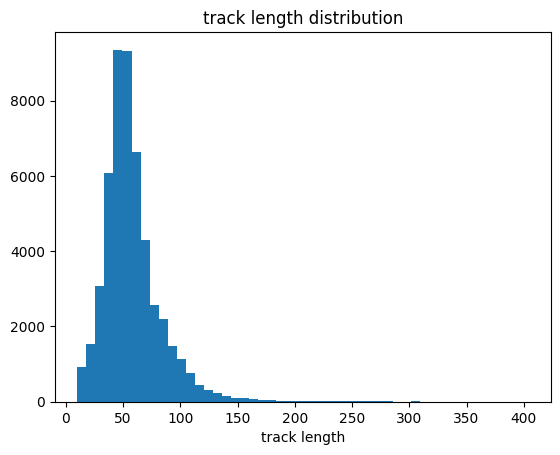

In [39]:
plt.hist(df_datacorr['len'], bins=50)
plt.title("track length distribution")
plt.xlabel("track length")

In [65]:
track_idx = list(track_idx2embeds.keys())[0]
embeds = track_idx2embeds[track_idx]
embeds

array([[0.28885692, 0.49755067, 0.8752916 , ..., 0.9090087 , 0.90730524,
        0.50137377],
       [0.17985933, 0.5305288 , 0.8164356 , ..., 0.5104127 , 0.50317085,
        0.12180575],
       [0.1434907 , 0.44528818, 0.5633509 , ..., 0.6120487 , 0.49296898,
        0.11338799],
       ...,
       [0.73658293, 0.5967559 , 1.1329923 , ..., 1.3312666 , 1.0401368 ,
        1.0939531 ],
       [0.91167396, 0.91849893, 1.6128439 , ..., 1.5967797 , 1.5148809 ,
        1.6157327 ],
       [1.0276184 , 1.220208  , 1.8383656 , ..., 1.7946615 , 1.870479  ,
        1.8701223 ]], dtype=float32)

In [66]:
np.correlate(embeds[:,0], embeds[:,0], 'full')

array([ 0.29683468,  0.44817007,  0.5241938 ,  0.22298592,  0.08716643,
        0.35812518,  0.23568669,  0.25397077, -0.06414275,  0.01356911,
        0.21931225,  0.3900351 ,  0.8458516 ,  0.62692446,  0.8770969 ,
        0.6999924 ,  0.695436  ,  0.76234335,  0.5604337 ,  0.6410649 ,
        0.09233723, -0.35530096, -0.7042368 , -1.1480347 , -1.0657886 ,
       -1.3942751 , -1.650561  , -1.4690279 , -1.5494    , -0.7490313 ,
       -1.2209038 , -0.35524356, -0.3211338 ,  0.17817754,  0.09437957,
       -0.21033844,  0.31026456, -0.42931885,  0.19661345, -0.27292868,
        0.11083978,  0.18671419, -0.6543369 ,  0.19495118, -0.7359258 ,
        0.27189508, -0.8604604 , -0.8021355 , -1.1575474 , -1.3491386 ,
       -0.6776365 , -1.5009224 , -0.91957104, -1.1661463 , -0.7613432 ,
       -0.06686389, -1.1789298 ,  0.277401  , -0.98362684,  0.12661067,
       -0.8687135 , -0.97927135, -0.6161875 , -1.3725507 ,  0.19334006,
       -0.2736301 ,  1.9832621 ,  2.1628702 ,  2.4127462 ,  4.39

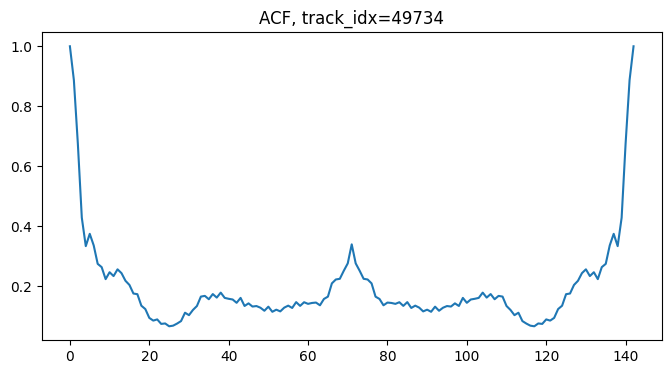

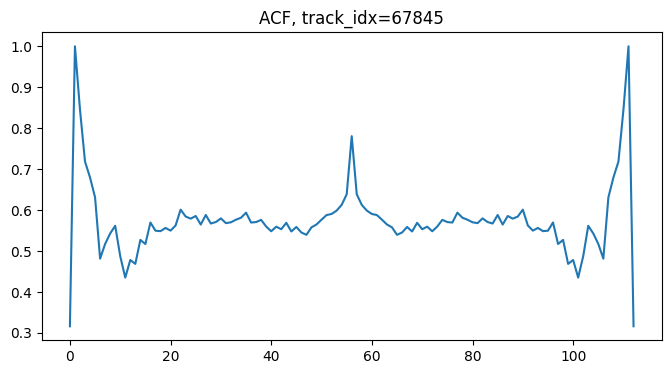

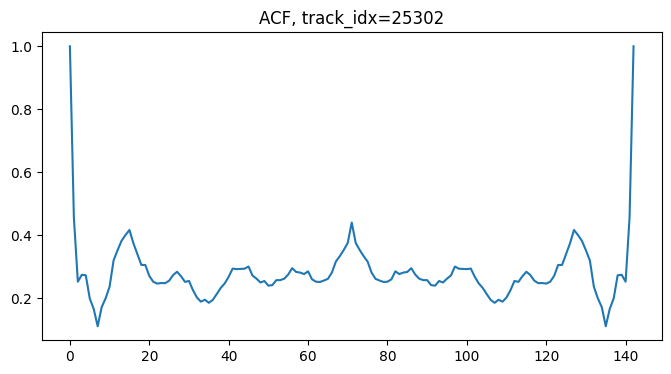

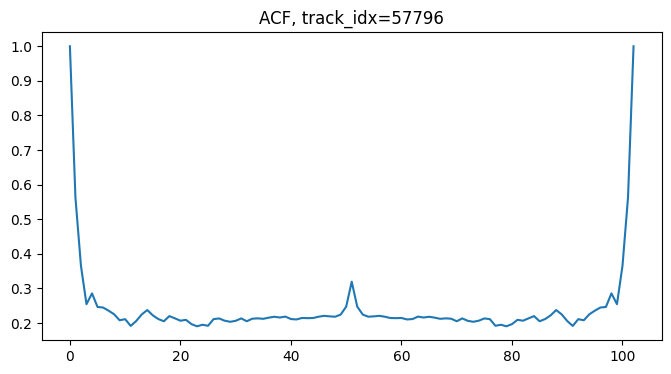

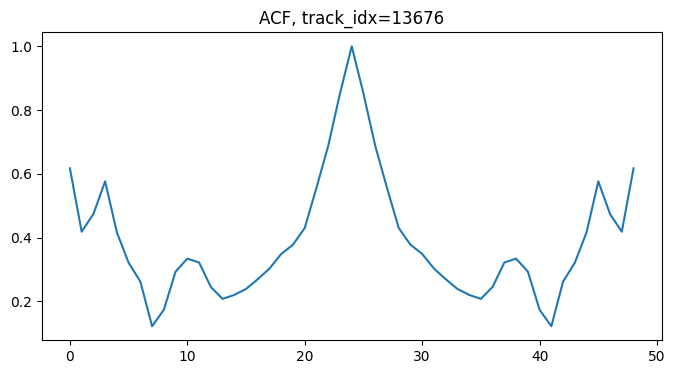

In [62]:
for track_idx in list(track_idx2embeds.keys())[:5]:
    embeds = track_idx2embeds[track_idx]
    ACF_arr = np.zeros(shape=(embeds.shape[1], embeds.shape[0]*2 - 1), dtype='float')
    for emb_idx in range(embeds.shape[1]):
        ACF_arr[emb_idx] = np.correlate(embeds[:,emb_idx], embeds[:,emb_idx], 'full')
        nonzeros = np.concatenate((np.arange(1, embeds.shape[0], 1), 
                                np.arange(embeds.shape[0], 0, -1)))
        ACF_arr[emb_idx] /= nonzeros
    ACF_sum = ACF_arr.sum(axis=0)
    ACF_sum /= max(ACF_sum)
    plt.figure(figsize=(8,4))
    plt.plot(ACF_sum)
    plt.title(f"ACF, {track_idx=}")